<a href="https://colab.research.google.com/github/Omar-Elhakim/Using-AI-in-machinery-fault-diagnosis/blob/master/Gp_Notebook_(2)%2C_TSAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TSAI Documentation + Tutorial notebooks: https://timeseriesai.github.io/tsai/tutorials.html, https://colab.research.google.com/github/timeseriesAI/tsai/blob/master/tutorial_nbs/01_Intro_to_Time_Series_Classification.ipynb

In [3]:
'''
In this notebook we will create a model that classifies a bearing signal as faulty or not.

Each channel in each sample will be considered as a different sample.

This approach is better because it's more flexible than making the samples per bearing or per machine.

Also, the predictions of each bearing individual channels can be aggregated and treat it as a prediction on the bearing itself
'''

'''
A very clear distinction needs to be made, which is the difference between a bearing related fault and a machine related fault.

A bearing related fault, is something that directly affects the components of the bearing itself (outer race, inner race, ball, and cage).

Meaning that if the model predicts a "bearing fault" it means that something is wrong with the bearing itself.

While machine faults, do not mean that the bearing itself is damaged, for example, misalignment is just that the coupling

between the motor and fan is offset by a certain distance, but there is nothing wrong in the bearing itself.

The model here predicts if an action needs to be done on the bearing itself.

Feel free to experiment with any fault you want, but make sure you understand how the dataframe is structured.
'''

'\nA very clear distinction needs to be made, which is the difference between a bearing related fault and a machine related fault.\n\nA bearing related fault, is something that directly affects the components of the bearing itself (outer race, inner race, ball, and cage).\n\nMeaning that if the model predicts a "bearing fault" it means that something is wrong with the bearing itself.\n\nWhile machine faults, do not mean that the bearing itself is damaged, for example, misalignment is just that the coupling\n\nbetween the motor and fan is offset by a certain distance, but there is nothing wrong in the bearing itself.\n\nThe model here predicts if an action needs to be done on the bearing itself.\n\nFeel free to experiment with any fault you want, but make sure you understand how the dataframe is structured.\n'

In [4]:
import pandas as pd #For dataset loading and manipulation
import numpy as np #For arrays operation
from collections import Counter #To count labels inside of lists

In [5]:
from google.colab import drive
drive.mount('/content/drive')
#Load the hr dataset, change its path.
df = pd.read_pickle(r"/content/drive/MyDrive/TimeWaveFormg GP Datasets Revised Final/hr.pickle")
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,ts,name,faults
0,"[[0.000167964, -5.34659e-05, 1.28447e-05, 9.03...",9.1120 C Hot Water Pump,"[[BearingFault, motor], [XC, machine], [Bearin..."
1,"[[0.009780156, 0.014624815, 0.019440233, 0.020...",Air RecFan 1.12302,"[[Looseness, machine], [Misalignment, machine]..."
2,"[[0.001560547, 0.001073043, -2.44838e-05, -0.0...",Air RecFan 1.12302,"[[Looseness, machine], [Misalignment, machine]..."
3,"[[-0.002804407, -0.001306111, 0.001502491, 0.0...",Air RecFan 1.12402A,"[[Looseness, machine], [Misalignment, machine]..."
4,"[[0.000500389, 0.00026631, -6.22153e-05, -0.00...",Vacuum Pump 5.1302,"[[Misalignment, machine], [Looseness, machine]..."


In [6]:
#Each entry in the row faults is a list of lists of faults.
#Each sublist of faults is structured in this way [FaultName, location]
df["faults"].explode().value_counts()

[Misalignment, machine]          222
[Flow, machine]                   90
[BearingFault, machine]           72
[BearingFault, motor]             68
[LXC, machine]                    56
[Coupling, machine]               53
[BearingLubrication, machine]     38
[SoftFoot, motor]                 37
[Looseness, machine]              33
[XC, machine]                     32
[BaseProblems, motor]             25
[Unbalance, machine]              24
[BeltProblem, machine]            23
[BearingLubrication, motor]       21
[AirGap, motor]                   21
[NAF]                             19
[BearingWear, machine]            19
[BaseProblems, machine]           17
[ElectricalProblem, motor]        17
[LXC, motor]                      12
[CockedBearing, machine]           9
[XC, motor]                        6
[BearingWear, motor]               5
[Looseness, motor]                 3
[SoftFoot, machine]                3
[MotorCoolingFan, motor]           2
[Rubbing, machine]                 1
N

In [7]:
#Create query lists that we will use to get the faults we want from the dataframe.
###### Change the names in faults_to_take if you want to include/exclude faults or experiment with other faults ######
faults_to_take = ["BearingFault", "BearingWear", "BearingLubrication", "Flow"]
locations = ["machine", "motor"]
query_strings = []
for fault in faults_to_take:
    for location in locations:
        query_strings.append([fault, location])
query_strings

[['BearingFault', 'machine'],
 ['BearingFault', 'motor'],
 ['BearingWear', 'machine'],
 ['BearingWear', 'motor'],
 ['BearingLubrication', 'machine'],
 ['BearingLubrication', 'motor'],
 ['Flow', 'machine'],
 ['Flow', 'motor']]

In [8]:
'''NOTE:
The reason we included the 'Flow' fault is related to the fact that even experienced analysts may someimes struggle
with differentiating it from 'Lubrication problem'

They appear nearly identical in the spectrum.

Most of the Lubrication and Flow labels you see in that dataframe were actually written like this in the report: "Machine has a bearing lubrication or flow problem".
'''

'NOTE:\nThe reason we included the \'Flow\' fault is related to the fact that even experienced analysts may someimes struggle\nwith differentiating it from \'Lubrication problem\'\n\nThey appear nearly identical in the spectrum.\n\nMost of the Lubrication and Flow labels you see in that dataframe were actually written like this in the report: "Machine has a bearing lubrication or flow problem".\n'

In [9]:
#The following are dataframe preprocessing steps to create the arrays we will use in the training.
df["motor_bearing"] = 0
df["machine_bearing"] = 0

for index, row in df.iterrows():
    faults = row["faults"]

    for query in query_strings:
        if query in faults:
            if "motor" in query:
                df.at[index, "motor_bearing"] = 1

            elif "machine" in query:
                df.at[index, "machine_bearing"] = 1

In [10]:
#ts_list contains the actual time series values, labels_list is a list of lists, each sublist has two values [motor_label, machine_label]
ts_list = df['ts'].to_list()
labels_list = df.apply(lambda row: [row['motor_bearing'], row['machine_bearing']], axis = 1)

In [11]:
len(ts_list), len(labels_list)

(232, 232)

In [12]:
#Separate each channel with its own label!
#First six channels which are the motor ones, will take the first element in each sublist of labels_list and vice versa with the other channels which are the machine's
ts_exploded = []
labels_exploded = []

for ts, label in zip(ts_list, labels_list):
    for i in range(len(ts)):
        ts_exploded.append(ts[i])
        if i < 6:
            labels_exploded.append(label[0])
        else:
            labels_exploded.append(label[1])

In [13]:
#Make sure the number of resulting time series is equal to number of samples in the original dataframe times 12, since each sample contains 4 bearings which in turn contain 3 channels each
len(ts_exploded), len(labels_exploded)

(2784, 2784)

In [14]:
#Initial distribution seems balanced, but let's see what happens after applying the sliding windows (note: not all time series have the same length, so we might actually end up with a more unbalanced dataset.)
Counter(labels_exploded)

Counter({1: 1386, 0: 1398})

In [15]:
#Rename the lists for more clarity
ts_list = ts_exploded
labels_list = labels_exploded

In [16]:
#FFT and Sliding window functions.

#Note: DON'T USE FFT
def GetFFT(ts):
        return np.abs(np.fft.rfft(ts * np.hanning(len(ts))))[:-1] * 2

def slide_ts(time_series, label, window_length=1024, overlap = 0, fft = False):

    time_series = time_series[~np.isnan(time_series)]

    windowed_ts_list = []
    windowed_labels = []

    step_size = int(window_length * (1 - overlap))

    for i in range(0, len(time_series) - window_length + 1, step_size):
        start = i
        end = i + window_length
        if fft == True:
            windowed_ts_list.append(GetFFT(time_series[start:end]))
        else:
            windowed_ts_list.append(time_series[start:end])

        windowed_labels.append(label)

    return (np.array(windowed_ts_list), np.array(windowed_labels))

In [17]:
!pip install tsai

In [18]:
#Import tsai
from tsai.all import *
computer_setup()

os              : Linux-6.1.58+-x86_64-with-glibc2.35
python          : 3.10.12
tsai            : 0.3.9
fastai          : 2.7.14
fastcore        : 1.5.29
torch           : 2.1.0+cu121
device          : cpu
cpu cores       : 1
threads per cpu : 2
RAM             : 12.67 GB
GPU memory      : N/A


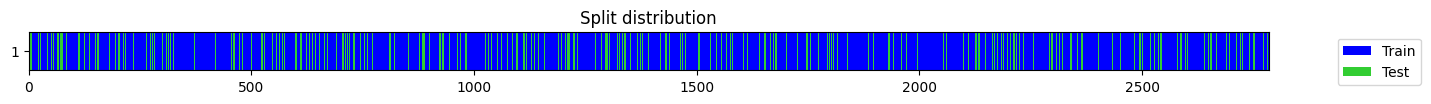

((#2228) [844,1596,440,503,2365,2192,1929,2563,2112,1066...],
 (#556) [723,1080,633,620,30,154,1566,1418,2542,1676...])

In [19]:
#Shuffle and do training and testing splitting.
#REMEMBER! Make sure to NOT include two windows of the same time series in training and testing simultaneously.
splits = get_splits(np.array(labels_list), valid_size=0.2, random_state=23, shuffle=True)
splits

In [20]:
#See counts of each label in training and testing.
print(Counter(list(np.array(labels_list)[splits[0]]))) #Training count
print(Counter(list(np.array(labels_list)[splits[1]]))) #Testing count

Counter({0: 1119, 1: 1109})
Counter({0: 279, 1: 277})


In [21]:
train_sample_indices = list(splits[0])
test_sample_indices = list(splits[1])

In [22]:
#Now that we made each time series in its container (train, test), we can now apply the sliding window safely.

window_length = 1024
overlap = 0.2



fft = False #Always make it False... for now.

X_train = []
y_train = []
X_test = []
y_test = []

for index in train_sample_indices:
    ts = ts_list[index]
    label = labels_list[index]
    data_pairs = slide_ts(ts, label=label, window_length=window_length, overlap=overlap, fft=fft)
    X_train.append(data_pairs[0])
    y_train.append(data_pairs[1])

# Iterate over the test samples
for index in test_sample_indices:
    ts = ts_list[index]
    label = labels_list[index]
    data_pairs = slide_ts(ts, label=label, window_length=window_length, overlap=overlap, fft=fft)
    X_test.append(data_pairs[0])
    y_test.append(data_pairs[1])

# Concatenate the train and test sets
X_train_arr = np.concatenate(X_train, axis=0)
y_train_arr = np.concatenate(y_train, axis=0)
X_test_arr = np.concatenate(X_test, axis=0)
y_test_arr = np.concatenate(y_test, axis=0)

In [23]:
#Let's count the distibutions and see again.
print(Counter(list(y_train_arr)))
print(Counter(list(y_test_arr)))

Counter({1: 6091, 0: 5401})
Counter({1: 1559, 0: 1373})


In [24]:
#See how they got unbalanced again after applying windowing?
#Let's apply undersampling on them, the following undersampling library not just removes samples randomly, but remove them in an intelligent way, and to not remove important samples.
from imblearn.under_sampling import NearMiss
undersample = NearMiss(version=1, n_neighbors=5)

In [25]:
# Now, apply the fit_resample method
X_train_arr, y_train_arr = undersample.fit_resample(X_train_arr, y_train_arr)

In [26]:
print(Counter(list(y_train_arr)))
print(Counter(list(y_test_arr)))

Counter({0: 5401, 1: 5401})
Counter({1: 1559, 0: 1373})


In [27]:
X, y, splits = combine_split_data([X_train_arr, X_test_arr], [y_train_arr, y_test_arr])

In [28]:
tfms  = [None, [TSStandardize(by_var=True), Categorize()]]
batch_tfms = [TSStandardize(by_sample=True)]
dls = get_ts_dls(X, y, splits=splits, tfms=tfms, shuffle_train=True, batch_tfms=batch_tfms, bs=[64,256])

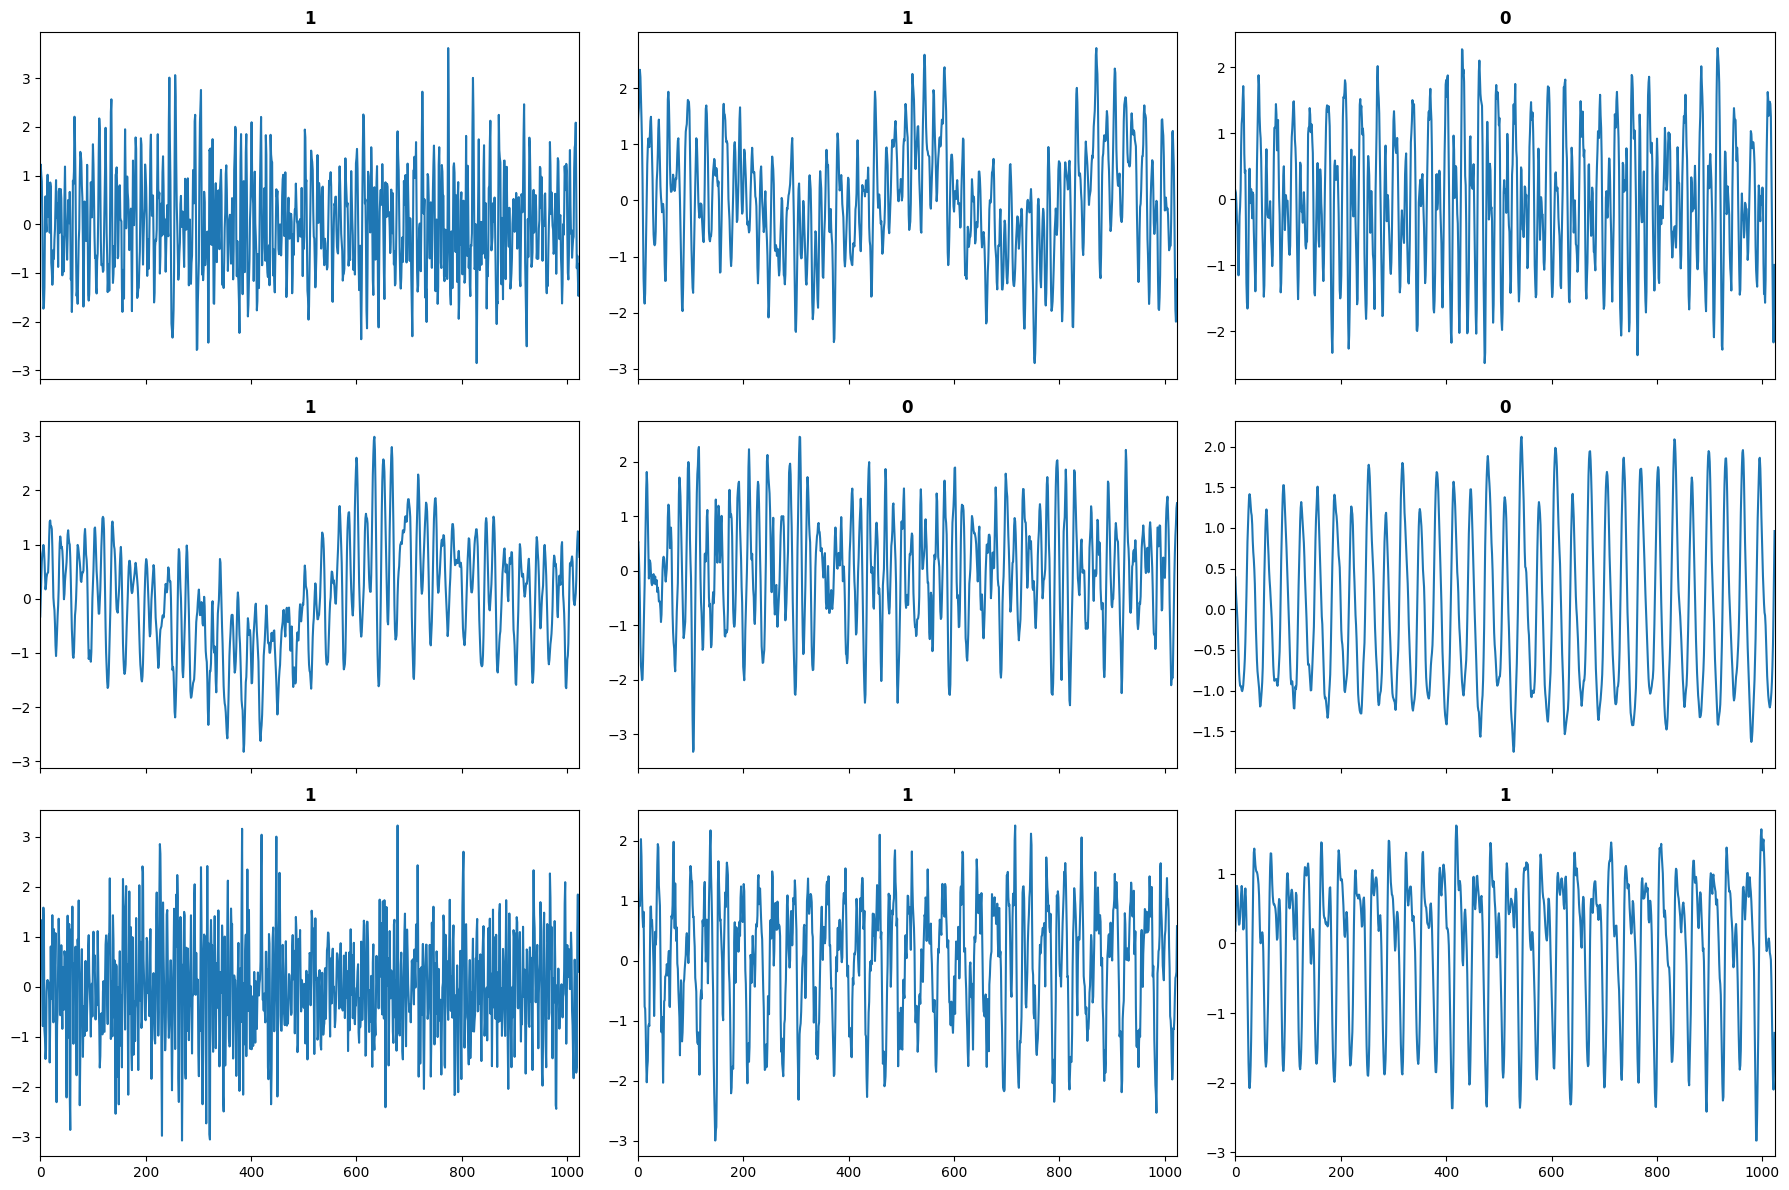

In [29]:
dls.show_batch(sharex=True)

##### TASK 1 #####
Callbacks: Stop the training of the model based on a given criteria.
Example: Stop training when the {metric} starts to decrease for {x} iterations

##### TASK 3 #####
Experiment with different variations of CNN (FCN), resnet, LSTM, LSTM_FCN, InceptionTime, Transofrmers (TST)

In [30]:
from   fastai.callback.all import *

In [31]:
f1=F1Score()

In [32]:
dls.vars

1

In [33]:
model = TST(c_in=dls.vars, c_out=dls.c , seq_len=dls.len)
earlystopping=EarlyStoppingCallback(monitor='f1' , comp=np.greater , patience=3)
savebestmodel=SaveModelCallback(monitor='f1', fname='best-model')
learn = Learner(dls, model, metrics=[accuracy, Precision(), Recall(), F1Score()] )

In [ ]:
learn.fit_one_cycle(15, lr_max=learn.lr_find(), cbs=[PredictionDynamics()])

In [ ]:
learn.show_probas()

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
valid_dl = dls.valid
valid_probas, valid_targets, valid_preds = learn.get_preds(dl=valid_dl, with_decoded=True)
valid_probas, valid_targets, valid_preds

In [ ]:
positive_probs = valid_probas[:, 1]

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


#Draw ROC curve to help us adjust the threshold to a better value.
fpr, tpr, thresholds = roc_curve(valid_targets, positive_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
#We can calculate the optimum value for the threshold from the following code:
youden_index = tpr - fpr
optimal_threshold = thresholds[np.argmax(youden_index)]
print("Optimal threshold:", optimal_threshold)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
positive_probs = valid_probas[:, 1]

threshold = 0.4 #I think its better to have more false positives than false negatives, because false negatives can lead to huge problems in teh machine if not looked upon
  ###Adjust threshold if required. Use the optimal one found in the previous cell.

valid_preds_adjusted = (positive_probs > threshold).long()

accuracy = accuracy_score(valid_targets, valid_preds_adjusted)
precision = precision_score(valid_targets, valid_preds_adjusted)
recall = recall_score(valid_targets, valid_preds_adjusted)
f1 = f1_score(valid_targets, valid_preds_adjusted)

print("Adjusted Threshold Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

In [ ]:
#Plot confusion matrix after adjsuting the threshold
from sklearn.metrics import confusion_matrix
import seaborn as sns


cm = confusion_matrix(valid_targets, valid_preds_adjusted)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels (Adjusted)')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Adjusted Threshold)')
plt.show()

Hyperparameter optimization.
https://github.com/timeseriesAI/tsai/discussions/138

Task 2 - Define the hyperparameters of the model, and do an optimzation study on them.

In [ ]:
!pip install optuna-integration

In [ ]:
import optuna
from optuna.integration import FastAIPruningCallback

num_epochs = 5
num_optuna_trials = 100

def objective(trial:optuna.Trial):
    # Define search space here. Supported search space are
    num_filters = trial.suggest_categorical('num_filters', [32, 64, 96, 128])
    dropout_rate = trial.suggest_float("dropout_rate", 0.0, 1.0)

    model = InceptionTimePlus(dls.vars, dls.c, nf=num_filters, fc_dropout=dropout_rate)
    learn = Learner(dls, model, metrics=accuracy, cbs=FastAIPruningCallback(trial))
    learn.fit_one_cycle(num_epochs, lr_max=1e-3)

    # return the valid_loss - learn.recorder.values returns [[train_loss, valid_loss, acc]]
    return learn.recorder.values[-1][1]

In [ ]:
study = optuna.create_study(direction='minimize', pruner=optuna.pruners.HyperbandPruner())
study.optimize(objective, n_trials=num_optuna_trials, show_progress_bar=True)

In [ ]:
print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

In [ ]:
all_arch_names